In [135]:
import cv2
import numpy as np

## Setting up camera

In [68]:
# def nothing(x):
#     pass

# cv2.namedWindow("Window")
# cv2.createTrackbar("Param Name", "Window", 0, 10, nothing)

In [69]:
def try_camera(func):
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25) # 0.25 turns OFF auto exp
    cap.set(cv2.CAP_PROP_AUTO_WB, 0.25) # 0.25 turns OFF auto WB

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        try:
            gray = func(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the resulting frame
            cv2.imshow('frame', gray)
        except:
            print("Nothing found...")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the cqapture
    cap.release()
    cv2.destroyAllWindows()
    return frame
    
frame = try_camera(lambda x : x)

## Part 1: Extracting Hand from Feed

In [70]:
np.save('bg_with_hand', frame)

In [71]:
# ! {"pip install matplotlib"}

In [72]:
# frame = np.load('open_palm.npy')
bg = np.load('bg.npy')
frame = np.load('bg_with_hand.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'bg.npy'

In [73]:
import matplotlib.pyplot as plt

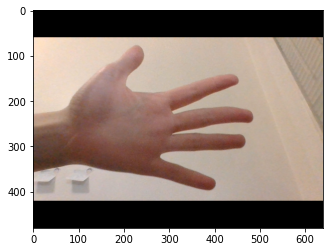

In [74]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [75]:
frame.shape

(480, 640, 3)

In [94]:
# daytime skinmask
# def get_skinmask(frame):
#     lower_HSV = np.array([0, 70, 0], dtype = "uint8")  
#     upper_HSV = np.array([25, 255, 255], dtype = "uint8")  

#     convertedHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  
#     skinMaskHSV = cv2.inRange(convertedHSV, lower_HSV, upper_HSV)  


#     lower_YCrCb = np.array((0, 138, 67), dtype = "uint8")  
#     upper_YCrCb = np.array((255, 173, 133), dtype = "uint8")  

#     convertedYCrCb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)  
#     skinMaskYCrCb = cv2.inRange(convertedYCrCb, lower_YCrCb, upper_YCrCb)  

#     skinMask = cv2.add(skinMaskHSV,skinMaskYCrCb)  
#     return skinMask

# nighttime skinmask
def get_skinmask(frame):
    lower_HSV = np.array([0, 153, 80], dtype = "uint8")  
    upper_HSV = np.array([25, 255, 255], dtype = "uint8")  

    convertedHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  
    skinMaskHSV = cv2.inRange(convertedHSV, lower_HSV, upper_HSV)  

    lower_YCrCb = np.array((0, 144, 83), dtype = "uint8")  
    upper_YCrCb = np.array((255, 173, 133), dtype = "uint8")  

    convertedYCrCb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)  
    skinMaskYCrCb = cv2.inRange(convertedYCrCb, lower_YCrCb, upper_YCrCb)  

    skinMask = cv2.add(skinMaskHSV,skinMaskYCrCb)
    return skinMask

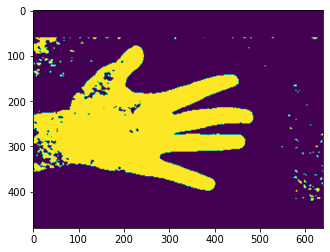

In [95]:
plt.imshow(get_skinmask(frame))

Testing Code

In [96]:
f = try_camera(get_skinmask)

In [97]:
def morph_and_blur(frame, skinMask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))  
    skinMask = cv2.erode(skinMask, kernel, iterations = 1)  
    skinMask = cv2.dilate(skinMask, kernel, iterations = 1)  

    # blur the mask to help remove noise, then apply the  
    # mask to the frame  
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0) 
    skin = cv2.bitwise_and(frame, frame, mask = skinMask)
    return skin

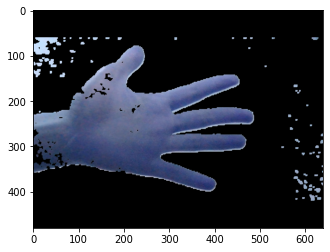

In [98]:
plt.imshow(morph_and_blur(frame, get_skinmask(frame)))

In [99]:
isolate = lambda x : morph_and_blur(x, get_skinmask(x))
f = try_camera(isolate)

## Part 2: Connected Components for Gesture Recognition

In [100]:
ok_hand = np.load('ok.npy')

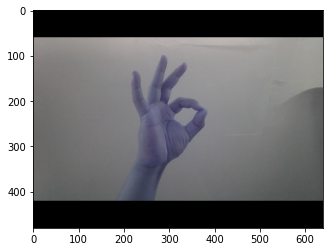

In [101]:
plt.imshow(ok_hand)

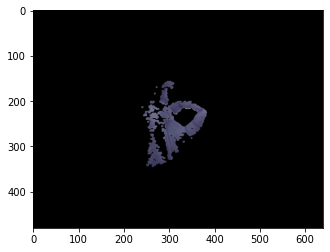

In [102]:
plt.imshow(isolate(ok_hand).astype(np.uint8))

In [103]:
def gray_thresh(frame):
    max_binary_value = 10
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)  
    ret, thresh = cv2.threshold(gray, 0, max_binary_value, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    return thresh # thresh if ret else None

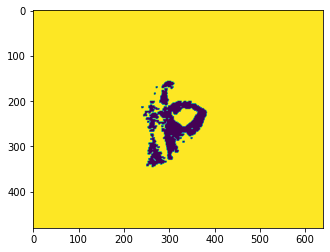

In [104]:
plt.imshow(gray_thresh(isolate(ok_hand)))

In [105]:
def arr2img(arr):
    arr = np.uint8(arr / np.max(arr) * 255)
    return cv2.merge([arr, arr, arr])

In [106]:
# try_camera(lambda x : arr2img(gray_thresh(isolate(x))))

In [107]:
def get_connect(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    return arr2img(markers)

In [108]:
marks = get_connect(gray_thresh(isolate(ok_hand)))

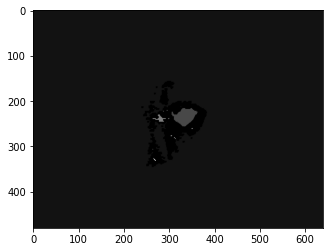

In [109]:
plt.imshow(marks)

Test out code so far...

In [110]:
render_comps = lambda x : get_connect(gray_thresh(isolate(x)))
# try_camera(render_comps)

In [111]:
def get_connect2(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    labeled_img = arr2img(markers)
    
    # sort by area of ROI
    statsSortedByArea = stats[np.argsort(stats[:, 4])]  
    roi = statsSortedByArea[-3][0:4]  
    x, y, w, h = roi  
    subImg = labeled_img[y:y+h, x:x+w]
    subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)
    
    _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    maxCntLength = 0  
    for i in range(0,len(contours)):  
        cntLength = len(contours[i])  
        if(cntLength>maxCntLength):  
            cnt = contours[i]  
            maxCntLength = cntLength  
    if(maxCntLength>=5):  
        ellipseParam = cv2.fitEllipse(cnt)
        (x,y), (MA, ma), angle = ellipseParam
        print(f"(x={x}, y={y}), (MA={MA}, ma={ma}), Angle={angle}")
        subImg = cv2.cvtColor(subImg, cv2.COLOR_GRAY2RGB);  
        subImg = cv2.ellipse(subImg,ellipseParam,(0,255,0),2)  

    subImg = cv2.resize(subImg, (0,0), fx=3, fy=3)
    return subImg

In [112]:
render_comps2 = lambda x : get_connect2(gray_thresh(isolate(x)))
try_camera(render_comps2)

Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
(x=1.672074317932129, y=1.9784127473831177), (MA=2.3035078048706055, ma=6.964688301086426), Angle=156.08518981933594
(x=1.672074317932129, y=1.9784127473831177), (MA=2.3035078048706055, ma=6.964688301086426), Angle=156.08518981933594
(x=4.8108601570129395, y=15.712464332580566), (MA=11.835806846618652, ma=27.493366241455078), Angle=168.3731689453125
(x=4.8108601570129395, y=15.712464332580566), (MA=11.835806846618652, ma=27.493366241455078), Angle=168.3731689453125
(x=3.0238003730773926, y=3.6817193031311035), (MA=5.763858795166016, ma=9.376694679260254), Angle=122.84039306640625
(x=3.0238003730773926, y=3.6817193031311035), (MA=5.763858795166016, ma=9.376694679260254), Angle=122.84039306640625
Nothing found...
(x=13.424102783203125, y=-6.0707159042358

(x=27.856033325195312, y=35.477577209472656), (MA=38.60888671875, ma=79.98397827148438), Angle=32.93048095703125
(x=27.856033325195312, y=35.477577209472656), (MA=38.60888671875, ma=79.98397827148438), Angle=32.93048095703125
(x=29.346498489379883, y=31.44074058532715), (MA=38.461612701416016, ma=76.08258056640625), Angle=41.86251449584961
(x=29.346498489379883, y=31.44074058532715), (MA=38.461612701416016, ma=76.08258056640625), Angle=41.86251449584961
(x=29.142684936523438, y=27.63652229309082), (MA=39.10866928100586, ma=74.0602035522461), Angle=45.757667541503906
(x=30.22406005859375, y=23.99203872680664), (MA=38.963321685791016, ma=71.73555755615234), Angle=51.74022674560547
(x=30.22406005859375, y=23.99203872680664), (MA=38.963321685791016, ma=71.73555755615234), Angle=51.74022674560547
(x=30.3321475982666, y=17.96236228942871), (MA=40.91815948486328, ma=70.60340881347656), Angle=51.99800109863281
(x=30.3321475982666, y=17.96236228942871), (MA=40.91815948486328, ma=70.603408813476

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Part 3: Tracking 2D Finger Positions

In [113]:
def get_gray_thresh(x):
    img = arr2img(1 * (gray_thresh(isolate(x)) == 0))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

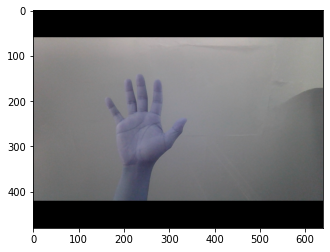

In [114]:
plt.imshow(np.load('open_palm.npy'))

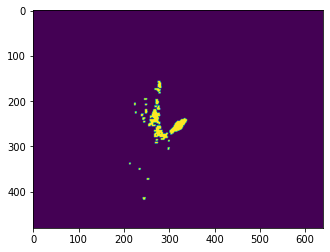

In [115]:
plt.imshow(get_gray_thresh(np.load('open_palm.npy')))

In [116]:
def get_hull(thresholdedHandImage):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    thresholdedHandImage = cv2.cvtColor(thresholdedHandImage, cv2.COLOR_GRAY2BGR)
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append(far)
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                
        print(fingerCount)
        
    return thresholdedHandImage

In [117]:
get_conv_img = lambda x : get_hull(get_gray_thresh(x))

0


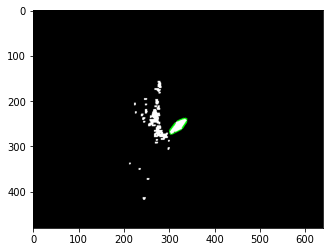

In [118]:
plt.imshow(get_conv_img(np.load('open_palm.npy')))

In [119]:
try_camera(get_conv_img)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
3
3
3
3
4
4
4
4
4
3
3
4
4
3
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
4
4
3
3
3
3
3
3
3
3
3
4
4
3
3
5
5
3
3
3
3
3
4
4
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
3
3
3
3
4
4
4
4
3
5
5
3
3
3
3
3
3
3
3
4
4
4
4
4
3
3
3
3
3
4
4
3
3
3
3
3
4
4
3
3
4
4
3
3
3
4
4
3
3
5
5
4
4
4
4
3
3
3
4
4
3
3
3
3
4
3
3
3
3
3
3
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
4
4
4
4
4
4
4
4
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
4
4
4
4
4
4
4
4
5
5
4
4
4
4
5
4
4
6
6
5
5
5
5
4
4
5
5
4
5
5
6
6
5
5
6
6
4
4
5
4
4
4
4
4
4
5
6
6
5
5
5
5
6
5
5
6
6
5
5
6
6
6
6
6
4
4
5
5
5
5
4
4
5
5
5
5
5
5
5
6
6
6
6
5
6
6
5
5
6
6
5
5
5
5
5
5
5
6
6
5
4
4
5
5
5
5
6
6
5
5
6
6
6
4
4
5
5
6
6
5
5
5
5
5
6
6
5
5
5
5
5
5
5
5
5
5


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Part 4: Control Mouse and Keyboard

Simple Gestures:
1. Finger Count: Use Pencil
    
2. Pinch - Draw/Click

3. Momentum Center - Mouse Cursor Location

Complex Gestures:

5. Closed + Center Circle Radius > 120 == Use Eraser

6. Pinch Axis Angle - Rotation

7. Open + Close + Open == Next Song / Rectangle

8. Open + Move Away Hand + Open == Prev Song / Circle

Demonstrated:

Finger Count, Circle Radius Change, Pinch, Momentum Center

In [196]:
import pyautogui

In [204]:
import pyautogui
def pencil():
    pyautogui.press(['alt', 'h', 'p', '1'])
    
def move_mouse(x, y, cap_w, cap_h):
    scaleX = 1920 / cap_w
    scaleY = 1080 / cap_h
    offsetX = 0
    offsetY = 0
    
    cX = offsetX + scaleX * x   
    cY = offsetY + scaleY * y 
    pyautogui.moveTo(cX, cY, duration=0.02, tween=pyautogui.easeInOutQuad)
    
def change_brush(mode=1):
    if mode == 1:
        pyautogui.press(['alt', 'h', 'b', 'enter'])
    if mode == 2:
        pyautogui.press(['alt', 'h', 'b', 'right', 'enter'])
    
def eraser():
    pyautogui.press(['alt', 'h', 'e', 'r'])
    
def draw():
    click()
    
    
def change_brush(mode=1):
    pyautogui.press(['alt', 'h', 'e', 'c'])

def rotate():
    pyautogui.press(['alt', 'h', 'k'])
def click():
    pyautogui.click(button='left')
def magnifier():
    pyautogui.press(['alt', 'h', 's', 'e', 'a', 'delete'])

In [205]:
from scipy.stats import mode

In [206]:
def paint_conv_on_frame(thresholdedHandImage, regular_img, centers, open_closes, finger_counts, cdists, cap, state,two_three_array):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText  = (10,30)
    bottomLeftCornerOfText2 = (10,60)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    thresholdedHandImage = regular_img
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    startEndPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append([far[i] for i in range(len(far))])
                    
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                    startEndPts.append([start[i] for i in range(len(start))])   
                    
        # Hand Tracking
        if len(startEndPts) > 5:
            M = cv2.moments(largestContour)  
            cX = 0 + 1 * int(M["m10"] / M["m00"])  
            cY = 0 + int(0.9 * M["m01"] / M["m00"])
            centers.append(np.array([cX, cY]))
            centers_mat = np.vstack(centers)
            center = np.mean(centers_mat, axis=0).astype(np.int)

            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = (10,30)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            cv2.circle(thresholdedHandImage, (center[0], center[1]), 5, [0,255,255], -1)
        
        # Draw Circle from Moment Center
        if len(startEndPts) > 5:
            pts = np.array(startEndPts)
            min_pts = np.array([cX, np.amin(pts, axis=0)[1]])
            dist = np.linalg.norm(min_pts - center, 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 60, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 120, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)
            cdists.append(dist)
        
        # Open Palm Detection
        if len(fingerPts) > 0 and len(startEndPts) > 5:
            pts = np.array(fingerPts)
            mean_pts = np.mean(pts, axis=0)
            min_pts = np.amin(pts, axis=0)
            dist = np.linalg.norm(min_pts - center, 2)

            open_closes.append(1)
            finger_counts.append(len(fingerPts))
            mean_finger_count = int(np.mean(finger_counts))
            
            state['num_fingers'] = mean_finger_count
            
            if mean_finger_count == 4:
                cv2.putText(thresholdedHandImage, f"Save: {mean_finger_count}", 
                        bottomLeftCornerOfText2, 
                        font, fontScale, fontColor, lineType)
            else:
                if mean_finger_count == 1:
                     two_three_array.append(2)
                if mean_finger_count == 2:
                     two_three_array.append(3)
                cv2.putText(thresholdedHandImage, f"Num Fingers: {mean_finger_count}", 
                            bottomLeftCornerOfText2, 
                            font, fontScale, fontColor, lineType)
        elif len(startEndPts) > 5:
            open_closes.append(0)
        else:
            open_closes.append(-1)
    else:
        open_closes.append(-1)
        
    if np.mean(open_closes) >= 0.33:
        cv2.putText(thresholdedHandImage, "Open", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
        state['open'] = True
        state['closed'] = False
    elif np.mean(open_closes) < 0.33 and np.mean(open_closes) >= -0.33:
        if cdists[0] < 120 and cdists[-1] > 120:
            cv2.putText(thresholdedHandImage, "Closed and Erased", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
            state['undo'] = True
        else:
            cv2.putText(thresholdedHandImage, "Closed", 
                bottomLeftCornerOfText, 
                font, fontScale, fontColor, lineType)
            state['open'] = False
            state['closed'] = True
    else:
        cv2.putText(thresholdedHandImage, "No Hand Detected", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
        state['open'] = False
        state['closed'] = False
            
    return thresholdedHandImage, centers, open_closes, two_three_array

def draw_center_of_ellipse(img, disp, center, pinches, angles, diff_angles):
    img = gray_thresh(isolate(img))
    try:
        ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
        markers = np.array(markers, dtype=np.uint8)  
        labeled_img = arr2img(markers)

        # sort by area of ROI
        statsSortedByArea = stats[np.argsort(stats[:, 4])]  
        roi = statsSortedByArea[-3][0:4]  
        x, y, w, h = roi
        
        subImg = labeled_img[y:y+h, x:x+w]
        subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)

        _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
        maxCntLength = 0  
        for i in range(0,len(contours)):  
            cntLength = len(contours[i])  
            if(cntLength>maxCntLength):  
                cnt = contours[i]  
                maxCntLength = cntLength  
        if(maxCntLength>=5):  
            ellipseParam = cv2.fitEllipse(cnt)
            (x_sub, y_sub), (MA, ma), angle = ellipseParam
            
            # Checking Location
            check_center1 = x > center[0]
            check_center2 = x + w > center[0]
            check_center3 = y < center[1]
            check_center4 = y + h < center[1]
            print(w * h)
            
            check_center = check_center2 and (check_center3 or check_center4)
            
            if check_center and (w * h > 1300 and w * h < 3000):
                # Draw Ellipse Location
                cv2.circle(disp, (x, y), 5, [100 if check_center1 else 255, 10, 0], 2)
                cv2.line(disp, (x, y), (x + w, y),[100, 10, 0],2)
                
                cv2.circle(disp, (x + w, y), 5, [100 if check_center2 else 255, 10, 0], 2)
                cv2.line(disp, (x + w, y), (x + w, y + h),[100, 10, 0],2)
                
                cv2.circle(disp, (x + h, y + h), 5, [100 if check_center3 else 255, 10, 0], 2)
                cv2.line(disp, (x + w, y + h), (x, y + h),[100, 10, 0],2)
                
                cv2.circle(disp, (x, y + h), 5, [100 if check_center4 else 255, 10, 0], 2)
                cv2.line(disp, (x, y + h), (x, y),[100, 10, 0],2)

                print(w * h, angle)
                pinches.append(1)
                if np.mean(pinches) > 0.8:
                    angles.append(int(angle))
                    diff_angles.append(int(angles[-1] - angles[0]))
                    return np.mean(pinches) > 0.8
                else:
                    angles.append(int(angles[-1]))
                    diff_angles.append(int(angles[-1] - angles[0]))
                    return False
            
        angles.append(int(angles[-1]))
        diff_angles.append(int(angles[-1] - angles[0]))
        pinches.append(0)
        return False
    except:
        angles.append(int(angles[-1]))
        diff_angles.append(int(angles[-1] - angles[0]))
        pinches.append(0)
        return False

def two_to_three(two_three_arr):
    half_way = len(two_three_arr) // 2
    if ( abs(2 - np.mean(two_three_arr[:half_way])) < 0.25 ) and (abs(3 - np.mean(two_three_arr[half_way:])) < 0.25):
        magnifier()
        return True
    return False
    
#  -----------next song and prev song ------------------------
def open_to_close(centers_arr, open_closes_arr, dist_start, dist_end, timer):
    indexes = np.where(np.array(open_closes_arr) == -1)
    open_close_arr = np.delete(open_closes_arr, indexes)
    half_way = len(open_closes_arr) // 2
    
    if (np.mean(open_closes_arr[:half_way]) > 0.8) and (np.mean(open_closes_arr[half_way:]) < 0.2):
        timer = 45
        print("open -> close")
        dist_start.append(centers_arr[-1])
        print(dist_start, dist_end)
        return dist_start, dist_end, timer
    if (np.mean(open_closes_arr[:half_way]) < 0.2) and (np.mean(open_closes_arr[half_way:]) > 0.8):
        dist_end.append(centers_arr[-1])
        print("close -> open")
        print(dist_start, dist_end)
        return dist_start, dist_end, timer
    return dist_start, dist_end, timer
# ------------------------------------------------------------

In [208]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25) # 0.25 turns OFF auto exp
cap.set(cv2.CAP_PROP_AUTO_WB, 0.25) # 0.25 turns OFF auto WB

centers_arr = []
open_closes_arr = [-1]
finger_counts = []
pinches = []
cdists = []
angles = [0]
diff_angles = [0, 0]
curr_angle = 0
mean_angles = [0] * 15
brush = 0
two_three_array = []
two_three_true =[]

#  -----------next song and prev song ------------------------
dist_start = []
dist_end = []
timer = 0
# ------------------------------------------------------------

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # frame = frame - bg
    
    state_dict = {
        'open': False, 'closed': False, 'pinch': False,
        'num_fingers': 0, 'undo': False, 'next': False,
        'prev': False
    }

    # Our operations on the frame come here
    # try:
    gray = get_gray_thresh(frame)
    disp, centers_arr, open_closes_arr,  two_three_array = paint_conv_on_frame(
        gray, frame, centers_arr, open_closes_arr, finger_counts,
        cdists, cap, state_dict,  two_three_array
    )
    if two_to_three(two_three_array):
        two_three_true.append(1)
    if sum(two_three_true) >= 10:
        #do the thing
        print("2 -> 3")
        two_three_true = []
    
    #  -----------next song and prev song ------------------------
    dist_start, dist_end, timer = open_to_close(centers_arr, 
        open_closes_arr, dist_start, dist_end, timer)
    timer -= 1
    if timer <= 0:
        dist_start, dist_end = [], []
        timer = 0
    if len(dist_start) >= 1 and len(dist_end) >=1:
        start_open_close = np.mean(dist_start, axis=0)
        end_open_close = np.mean(dist_end, axis=0)
        open_close = end_open_close[0]-start_open_close[0]
        if open_close > 0:
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText  = (10,125)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            # timer = 0
            cv2.putText(disp, "Next Song", 
                            bottomLeftCornerOfText, 
                            font, fontScale, fontColor, lineType)
            state_dict['next'] = True
        else:
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText  = (10,125)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            # timer = 0
            cv2.putText(disp, "Prev Song", 
                            bottomLeftCornerOfText, 
                            font, fontScale, fontColor, lineType)
            state_dict['prev'] = True
    # ------------------------------------------------------------
    
    ellipse_found = False
    if len(centers_arr) > 1:
        centers_mat = np.vstack(centers_arr)
        ellipse_found = draw_center_of_ellipse(
            frame, disp, np.mean(centers_mat, axis=0).astype(np.int), 
            pinches, angles, diff_angles
        )
    
    if ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText  = (10, 90 + 60)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, f"Pinch. ({np.mean(angles)}, {np.mean(diff_angles)}).", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    
    max_angle_index = np.argmax(np.array(mean_angles))
    min_angle_index = np.argmax(-1 * np.array(mean_angles))
    if angles and np.max(mean_angles) - np.min(mean_angles) > 40 and ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText3= (10, 200 + 60)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, "rotate ccw", 
                        bottomLeftCornerOfText3, 
                        font, fontScale, fontColor, lineType)
        curr_angle += 5
        
    font                    = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText  = (10,90)
    fontScale               = 1
    fontColor               = (255,255,255)
    lineType                = 2
    cv2.putText(disp, f"Curr Angle: {int(np.mean(angles))}", 
                    bottomLeftCornerOfText, 
                    font, fontScale, fontColor, lineType)
    mean_angles.append(int(np.mean(angles)))
    
    
    # Control Based on State
    if len(centers_arr) > 1:
        if state_dict['num_fingers'] == 4:
            pencil()
        elif state_dict['undo']:
            eraser()
        elif state_dict['next'] or state_dict['prev']:
            change_brush()
        elif ellipse_found and state_dict['open'] and not state_dict['closed']:
            if angles and np.max(mean_angles) - np.min(mean_angles) > 30:
                rotate()
            else:
                centers_mat = np.vstack(centers_arr)
                center = np.mean(centers_mat, axis=0).astype(np.int)
                move_mouse(center[0], center[1], cap.get(3), cap.get(4))
                click()
        elif not ellipse_found and state_dict['closed'] and not state_dict['open']:
            centers_mat = np.vstack(centers_arr)
            center = np.mean(centers_mat, axis=0).astype(np.int)
            move_mouse(center[0], center[1], cap.get(3), cap.get(4))
    
        
    if len(centers_arr) > 20:
        centers_arr = centers_arr[1:]
    if len(open_closes_arr) > 15:
        open_closes_arr = open_closes_arr[1:]
    if len(finger_counts) > 15:
        finger_counts = finger_counts[1:]
    if len(pinches) > 15:
        pinches = pinches[1:]
    if len(angles) > 15:
        angles = angles[1:]
    if len(diff_angles) > 15:
        diff_angles = diff_angles[1:]
    if len(mean_angles) > 15:
        mean_angles = mean_angles[1:]
    if len(cdists) > 15:
        cdists = cdists[1:]
        
    # Display the resulting frame
    cv2.imshow('frame', disp)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

8
45
70
70
2600
1462
7171
7931
6675
8624
9200
close -> open
[] [array([157, 246])]
189
close -> open
[] [array([158, 245])]
7208
close -> open
[] [array([156, 245])]
8136
close -> open
[] [array([157, 245])]
8176
close -> open
[] [array([158, 244])]
5616
10101
7182
5994
4896
6954
6496
380
4648
5418
5696
8240
8881
6392
6392
6240
5850
5850
5733
3920
5874
5874
6164
3850
3800
6120
6603
6603
6603
6887
6248
6248
6674
5658
5658
5785
5785
5184
5160
5160
5828
9153
9153
132
9085
9085
266
247
247
8736
9164
9164
224
224
104
8436
8814
216
8140
8140
8701
156
288
117
8624
8927
8547
180
180
414
527
527
120
224
100
100
8769
8769
8880
9153
9153
576
8800
196
126
352
221
8190
612
2 -> 3
952
8560
4697
open -> close
[array([ 73, 180])] []
open -> close
[array([ 73, 180]), array([ 73, 180])] []
open -> close
[array([ 73, 180]), array([ 73, 180]), array([ 73, 180])] []
open -> close
[array([ 73, 180]), array([ 73, 180]), array([ 73, 180]), array([ 73, 180])] []
2 -> 3
open -> close
[array([ 73, 180]), array([